# Merging data from different sources

Based on the previous analysis the variables related with the ticket amount (judge, fine amounts, discount),
the geographical position (lat,lon,address,zip_code), and the hearing waiting time are reasonable features to distinguish between compliant and non-compliant tickets. Let's take for the moment just the variables related with the fine amount and the geog. distribution:

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
# dataset with addresses and ticket ids
dfa = pd.read_csv("addresses.csv")
dfa.dropna(inplace=True)
# dataset with lat lon coordinates for different addresses
dflalo = pd.read_csv("latlons.csv")
dflalo.dropna(inplace=True)
# parsing addresses from both dataframes so they have similar format
address_parser = lambda x: x.split(",")[0].strip()
dfa["address"] = dfa["address"].apply(address_parser)
dflalo["address"]  = dflalo["address"].apply(address_parser)


#joining  data sets by address
print("rows in dfa: {}".format(len(dfa)))
df_geoloc = dfa.set_index("address").join(dflalo.set_index("address"),how="left")
#print(len(df_geoloc))
# An address may be appear on several tickets, so we want a dataframe whose index is the ticket id. by taking the mean only the numerical variables (lat lon) remain 
df_geoloc = df_geoloc.groupby("ticket_id").agg("mean")
# we merge the previous dataframe (with index ticket id, and cols (lat,lon) ) with dfa to get again the addresses info
df_geoloc = df_geoloc.merge(dfa,left_index=True,right_index=True)
print("rows after joining by address with latlon df: {}".format(len(df_geoloc)))

#we drop na values just to keep tickets with full info about address, lat and lon.
df_geoloc.dropna(inplace=True)
df_geoloc.set_index("ticket_id",inplace=True)
print("rows (e.g. number of tickets) with merged info (lat,lon, address): {}".format(len(df_geoloc)))
df_geoloc.head(5)

rows in dfa: 311307
rows after joining by address with latlon df: 266319
rows (e.g. number of tickets) with merged info (lat,lon, address): 266316


,lat,lon,address
ticket_id,,,
37070,42.383385,-83.072582,14335 minock
37852,42.383422,-83.072483,4488 freer
38601,42.359916,-83.115051,6575 canton
37472,42.393440,-83.127929,6340 faust
37468,42.389689,-83.134415,6340 faust


In [3]:
#loading dataset:

df = pd.read_csv("train.csv",index_col="ticket_id", encoding = "ISO-8859-1",low_memory=False) 
df1= df[ ["disposition", "fine_amount","discount_amount", "judgment_amount", "compliance"]].copy()

print("initial number of tickets: {}".format(len(df1)))
df1.dropna(inplace=True)
l = len(df1)
print("after droping Nan values: {}".format(l))
df1 = df1.join(df_geoloc,how="left")
df1.dropna(inplace=True)
print("after joinning dataframe with lat,lon info: {} ({:0.1f}%)".format(len(df1), 100*len(df1)/l))

initial number of tickets: 250306
after droping Nan values: 159880
after joinning dataframe with lat,lon info: 138117 (86.4%)


**Before scaling and encoding** the features we separate a train-test sets in order to avoid *data leakage* of the data distribution through the scalers parameters further employed:

In [4]:
from sklearn.model_selection import train_test_split
target = 'compliance'
features = df1.columns.drop(target)
X_train, X_test, y_train, y_test = train_test_split(df1[features], df1[target], random_state=0,train_size=0.85)

# Feature Engineering

In [5]:
street_parser = lambda x: " ".join( x.split(",")[0].split(" ")[1:]).strip()
df1["street"] = df1["address"].apply(street_parser)
df1["zip_code"] = df1["address"].str.findall('\d+').apply( lambda x: x[0])
#encoding categorical variables:
for i in ["compliance","disposition","zip_code","street","address"]:
    df1[i] = df1[i].astype("category")
df1.head(5)

,disposition,fine_amount,discount_amount,judgment_amount,compliance,lat,lon,address,street,zip_code
ticket_id,,,,,,,,,,
37852,Responsible by Default,250.0,0.0,305.0,0.0,42.383422,-83.072483,4488 freer,freer,4488
42751,Responsible by Default,250.0,0.0,305.0,0.0,42.389290,-83.134006,13902 monte vista,monte vista,13902
42753,Responsible by Default,250.0,0.0,305.0,0.0,42.374155,-83.036099,13902 monte vista,monte vista,13902
37027,Responsible by Default,50.0,0.0,85.0,0.0,42.339391,-83.019373,8549 prairie,prairie,8549
37202,Responsible by Default,3500.0,0.0,3880.0,0.0,42.342550,-83.137853,3705 palmer,palmer,3705


In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138117 entries, 37852 to 284333
Data columns (total 10 columns):
disposition        138117 non-null category
fine_amount        138117 non-null float64
discount_amount    138117 non-null float64
judgment_amount    138117 non-null float64
compliance         138117 non-null category
lat                138117 non-null float64
lon                138117 non-null float64
address            138117 non-null category
street             138117 non-null category
zip_code           138117 non-null category
dtypes: category(5), float64(5)
memory usage: 11.5 MB


## Encoding  categorical features

The "disposition" variable has only 4 unique values, so we use a **one-hot encoding** strategy to obtain the features:

In [7]:
df1["disposition"] = df1["disposition"].apply(  lambda x: str(x).split("by")[1].strip().lower()  )

In [8]:
disposition_dummies = pd.get_dummies(data=df1["disposition"],prefix="responsible_by")
df1 = pd.concat([ df1.drop(columns="disposition") , disposition_dummies],axis=1)
df1.head(3)

,fine_amount,discount_amount,judgment_amount,compliance,lat,lon,address,street,zip_code,responsible_by_deter,responsible_by_admission,responsible_by_default,responsible_by_determination
ticket_id,,,,,,,,,,,,,
37852,250.0,0.0,305.0,0.0,42.383422,-83.072483,4488 freer,freer,4488,0,0,1,0
42751,250.0,0.0,305.0,0.0,42.389290,-83.134006,13902 monte vista,monte vista,13902,0,0,1,0
42753,250.0,0.0,305.0,0.0,42.374155,-83.036099,13902 monte vista,monte vista,13902,0,0,1,0


For  "zip_code" and "street" variables, the number of unique values is rather large, a one-hot encoding would generate way too many features. For them we will use a **binary encoding** technique. It consists first on encoding each value of the categorical variable into integers and then transforming then into binary. Each digit of the binary expression will be a feature.

In [9]:
for i in ["zip_code","street","address"]:
    unique_values = len(df1[i].unique())
    bin_unique_values = bin(unique_values)
    len_bin_unique_values = len(bin_unique_values.split('0b')[1]) +1
    print("Variable {}:\n- {} unique values\n- max. binary representation: {}\n- binary-encoded generated features: {}\n".format(i,unique_values,bin_unique_values,len_bin_unique_values))

Variable zip_code:
- 17666 unique values
- max. binary representation: 0b100010100000010
- binary-encoded generated features: 16

Variable street:
- 1696 unique values
- max. binary representation: 0b11010100000
- binary-encoded generated features: 12

Variable address:
- 64932 unique values
- max. binary representation: 0b1111110110100100
- binary-encoded generated features: 17



In [10]:
#previously: pip3 install category_encoders
import category_encoders as ce
bin_encoder =  ce.BinaryEncoder(cols=["zip_code","street","address"],return_df=True)
df1 = bin_encoder.fit_transform(df1)
df1.columns

Index(['fine_amount', 'discount_amount', 'judgment_amount', 'compliance',
       'lat', 'lon', 'address_0', 'address_1', 'address_2', 'address_3',
       'address_4', 'address_5', 'address_6', 'address_7', 'address_8',
       'address_9', 'address_10', 'address_11', 'address_12', 'address_13',
       'address_14', 'address_15', 'address_16', 'street_0', 'street_1',
       'street_2', 'street_3', 'street_4', 'street_5', 'street_6', 'street_7',
       'street_8', 'street_9', 'street_10', 'street_11', 'zip_code_0',
       'zip_code_1', 'zip_code_2', 'zip_code_3', 'zip_code_4', 'zip_code_5',
       'zip_code_6', 'zip_code_7', 'zip_code_8', 'zip_code_9', 'zip_code_10',
       'zip_code_11', 'zip_code_12', 'zip_code_13', 'zip_code_14',
       'zip_code_15', 'responsible_by_deter', 'responsible_by_admission',
       'responsible_by_default', 'responsible_by_determination'],
      dtype='object')

## Scaling  numerical features and removing outliers

For the features related with money amounts we will normalize the data but not center around the mean.  
For the lat and long features we will center around the mean and then normalize.  
We will use a `RobustScaler` normalizer as it uses the data within specified *quartiles* to scale the distributions, making it more robust to outlier values

In [11]:
from sklearn.preprocessing import RobustScaler

scalers = {}
for i in ['fine_amount', 'discount_amount', 'judgment_amount']:
    si = RobustScaler(quantile_range=(0,85),with_centering=False)
    values = si.fit_transform(df1[i].values.reshape(-1, 1)).reshape(-1)
    df1[str('scaled_'+i)] = pd.Series(index=df1[i].index,data=values)
    #df1.pop(i)
    scalers[i] = si

All the data points with a lat-lot distance > 2 from the origin are dropped for the training:

In [12]:
origin_distance = lambda  x: np.sqrt( x["scaled_lat"]*x["scaled_lat"] + x["scaled_lon"]*x["scaled_lon"] )
outliers = df1.where( df1.apply(origin_distance,axis=1) > 2 )
outliers.dropna(inplace=True)
print("compliance values for outliers: {}".format(outliers.compliance.unique()))
df1.drop(index=outliers.index,inplace=True)

compliance values for outliers: [0.0]
Categories (1, float64): [0.0]


<IPython.core.display.Javascript object>


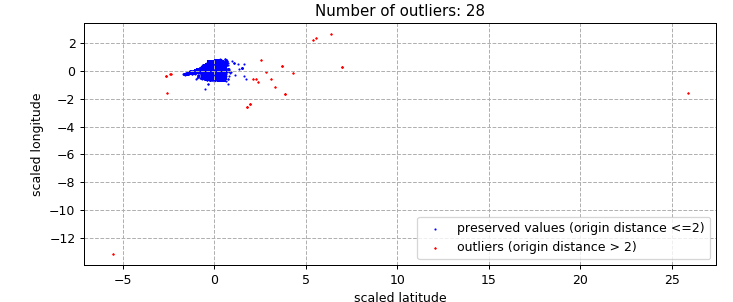

In [14]:
plt.figure()
plt.scatter(df1.scaled_lat,df1.scaled_lon,marker='o',c="b",s=0.5,label="preserved values (origin distance <=2)")
plt.scatter(outliers.scaled_lat,outliers.scaled_lon,marker='*',c="r",s=1,label="outliers (origin distance > 2)")
plt.xlabel("scaled latitude")
plt.ylabel("scaled longitude")
plt.title("Number of outliers: {}".format(len(outliers)) )
plt.grid(linestyle='--')
plt.legend(loc="lower right")
plt.tight_layout()

`RobustScaler` removes the median and scales the data according to the quantile range (IQR). For latitute and longitude we know that almost all the tickets are placed in the metropolitan area so we can  take and  IQR range rather large: (10%, 90%)

In [15]:
for i in ["lat","lon"]:
    si = RobustScaler(quantile_range=(10,90))
    values = si.fit_transform(df1[i].values.reshape(-1, 1)).reshape(-1)
    df1[str('scaled_'+i)] = pd.Series(index=df1[i].index,data=values)
    #df1.pop(i)
    scalers[i] = si

<IPython.core.display.Javascript object>


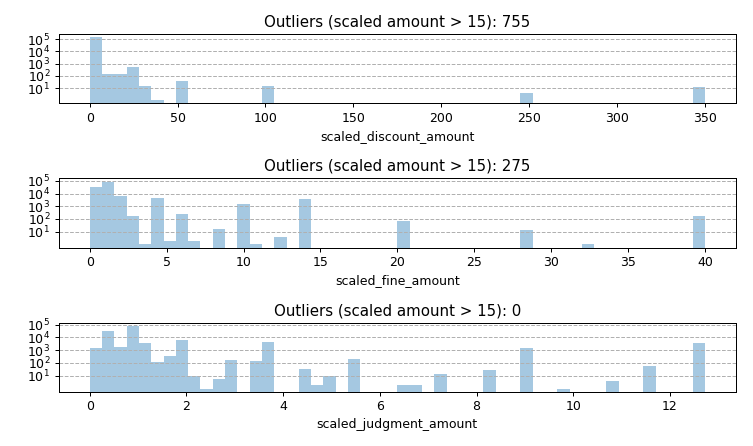

In [17]:
plt.subplots(3,1)
for i,j in enumerate(['scaled_discount_amount', 'scaled_fine_amount', 'scaled_judgment_amount']):
    plt.subplot(3,1,i+1)
    sns.distplot(df1[j],kde=False,norm_hist=False)
    plt.gca().set_yscale("log")
    plt.grid(linestyle='--',axis="y")
    plt.gca().set_yticks([1e1,1e2,1e3,1e4,1e5])
    plt.tight_layout()
    outliers = df1[j].where( df1[j]>15).dropna()
    plt.title("Outliers (scaled amount > 15): {}".format( outliers.count() ) )
    #dropping outliers
    df1.drop(index=outliers.index,inplace=True)

## Dataset with final features:

In [18]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137059 entries, 37852 to 284333
Data columns (total 60 columns):
fine_amount                     137059 non-null float64
discount_amount                 137059 non-null float64
judgment_amount                 137059 non-null float64
compliance                      137059 non-null category
lat                             137059 non-null float64
lon                             137059 non-null float64
address_0                       137059 non-null int64
address_1                       137059 non-null int64
address_2                       137059 non-null int64
address_3                       137059 non-null int64
address_4                       137059 non-null int64
address_5                       137059 non-null int64
address_6                       137059 non-null int64
address_7                       137059 non-null int64
address_8                       137059 non-null int64
address_9                       137059 non-null int64
address_

# Model development

In [19]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


In [ ]:
# grid search with 5% of data and estimate time
# consider better parameters of grid values
# plot cv results
# plot highest coefficients for model
# plot decision function, previous apply and PCA

In [ ]:
logic_reg = LogisticRegression()
grid_values = {'C': [1e-1, 1, 1e1, 50, 1e2], 'penalty':['l1','l2']}
grid_clf = GridSearchCV(logic_reg,param_grid=grid_values,scoring='roc_auc',cv=5, n_jobs=-1)
grid_clf.fit(X_train, y_train)

In [ ]:
import pandas as pd
import numpy as np

def blight_model():
    ################## Preparing training data      
    df = pd.read_csv("train.csv",index_col="ticket_id", encoding = "ISO-8859-1") 
    vars_for_model = ["fine_amount","discount_amount","judgment_amount","disposition","compliance"]
    df1= df[ vars_for_model ]
    df1.dropna(inplace=True) 
    # encoding disposition
    df1["disposition"] = df1["disposition"].astype("category")
    df1 = pd.get_dummies(df1,prefix="disposition",columns=["disposition"])
    
    #################### The model 
    from sklearn.model_selection import GridSearchCV
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_auc_score
    
    target="compliance"
    features = df1.columns.tolist()
    features.remove(target)
    
    X_train = df1[features].values 
    y_train = df1[target].values

    scaler=MinMaxScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)

    logic_reg = LogisticRegression()
    grid_values = {'C': [100, 120, 130, 140, 150, 170], 'penalty':['l1','l2']}
    grid_clf = GridSearchCV(logic_reg,param_grid=grid_values,scoring='roc_auc',n_jobs=-1)
    grid_clf.fit(X_train_scaled, y_train)

    ################### preparing test set 
    df_cv = pd.read_csv("test.csv",index_col="ticket_id", encoding = "ISO-8859-1")
    df1_cv = df_cv[ vars_for_model[:-1] ]
    df1_cv["disposition"] = df1_cv["disposition"].astype("category")
    df1_cv = pd.get_dummies(df1_cv,prefix="disposition",columns=["disposition"])
    df1_cv["fine_amount"].fillna(0)
    df1_cv = df1_cv[ features ]

    ################### predictions
    index_cv = df1_cv.index
    X_cv = df1_cv.values 
    X_cv_scaled = scaler.transform(X_cv)
    y_cv_prob   = grid_clf.predict_proba(X_cv_scaled)
    y_cv_prob   = y_cv_prob[:,1]
    
    return pd.Series(data=y_cv_prob,index=index_cv)